In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

data = pd.read_csv('laptop_data.csv')

data.shape

data.head()

# Currency equalization
data['Price'] = data['Price'].apply(lambda x: x/16)



Dropping unwatned Columns and removing units written after values

In [21]:
data.drop(columns=['Unnamed: 0'], inplace=True)
## Remove KG GB and convert the columns to numeric
data['Ram'].replace('GB','',inplace=True, regex=True)
data['Weight'].replace('kg','',inplace=True, regex=True)

data['Ram'] = data['Ram'].astype('int32')
data['Weight'] = data['Weight'].astype('float32')

# Basic Graph

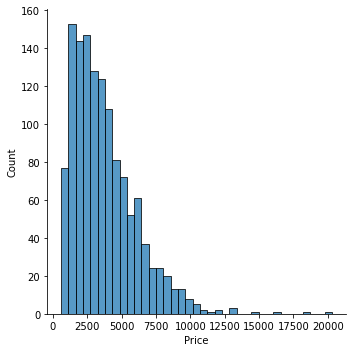

In [22]:
#Price Distribution

sns.displot(data['Price'])
plt.show()

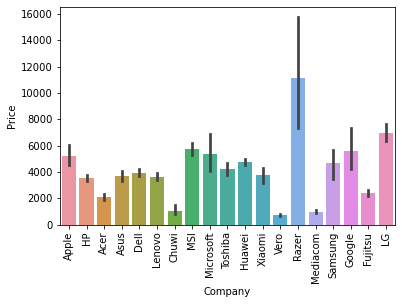

In [23]:
#Company to Price Distribution

sns.barplot(x='Company',y='Price',data=data)

plt.xticks(rotation = 90)
plt.show()

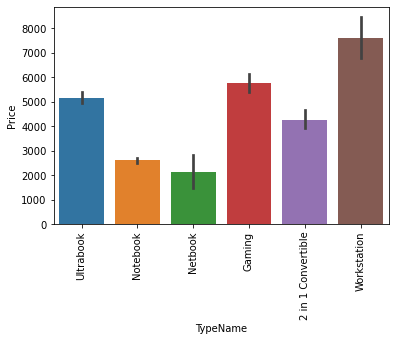

In [24]:
#Type of Laptop to Price Distribution
sns.barplot(x='TypeName',y='Price',data=data)

plt.xticks(rotation = 90)
plt.show()

# Aditional Data Enginering

In [25]:
# Adding TouchScreen Colum to the data

data['Touchscreen'] = data['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0) #LUP

data['IPS'] = data['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0) 

def x_res(s):
    return s.split()[-1].split('x')[0]

def y_res(s):
    return s.split()[-1].split('x')[1]

data['X_res'] = data['ScreenResolution'].apply(x_res).astype('int32')
data['Y_res'] = data['ScreenResolution'].apply(y_res).astype('int32')

#PPI Pixel per inch
data['Ppi'] = (((data['X_res']**2) + (data['Y_res']**2)**0.5)/data['Inches']).astype('float32')



In [26]:
# Price correlation with other features

data.corr()['Price'].sort_values(ascending=False)

Price          1.000000
Ram            0.743007
X_res          0.556529
Y_res          0.552809
Ppi            0.480376
IPS            0.252208
Weight         0.210370
Touchscreen    0.191226
Inches         0.068197
Name: Price, dtype: float64

# Prepering Data for Machine Learning Algorythms

In [27]:
# Removing non important features
data.drop(columns=(['ScreenResolution', 'Inches','X_res','Y_res']), inplace=True)

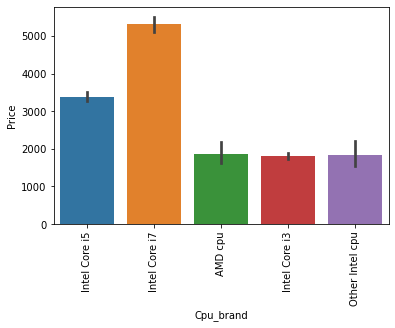

In [28]:
#CPU column
data
def fetch_processor(x):
    cpu_name = " ".join(x.split()[0:3])
    if cpu_name == 'Intel Core i7' or cpu_name == 'Intel Core i5' or cpu_name == 'Intel Core i3':
        return cpu_name
    elif cpu_name.split()[0] == 'Intel':
        return 'Other Intel cpu'
    else:
        return 'AMD cpu'
data['Cpu_brand'] = data['Cpu'].apply(lambda x: fetch_processor(x))



sns.barplot(x=data['Cpu_brand'],y=data['Price'])
plt.xticks(rotation='vertical')
plt.show()

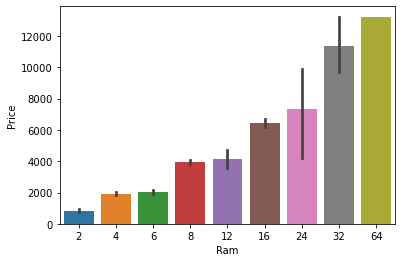

In [29]:
#RAM column

sns.barplot(x=data['Ram'],y=data['Price'])
plt.show()

In [30]:
# data drive column
def get_numbers(x):
    return re.sub('\D','',x)

data['Memory'] = data['Memory'].astype(str).replace('.0','')
data['Memory'] = data['Memory'].str.replace('GB','')
data['Memory'] = data['Memory'].str.replace('TB','000')

new = data["Memory"].str.split("+", n = 1, expand = True)

data['First'] = new[0]
data['Second'] = new[1]

data['First'] = data['First'].str.strip()

data['Layer1HDD'] = data['First'].apply(lambda x: 1 if 'HDD' in x else 0)
data['Layer1SSD'] = data['First'].apply(lambda x: 1 if 'SSD' in x else 0 )
data['Layer1Hybrid'] = data['First'].apply(lambda x: 1 if 'Hybrid' in x else 0)
data["Layer1Flash_Storage"] =  data['First'].apply(lambda x: 1 if 'Flash' in x else 0)
data['First'] = data['First'].apply(lambda x: get_numbers(x))

data['Second'].fillna('0',inplace=True)
data['Layer2HDD'] = data['Second'].apply(lambda x: 1 if 'HDD' in x else 0)
data['Layer2SSD'] = data['Second'].apply(lambda x: 1 if 'SSD' in x else 0 )
data['Layer2Hybrid'] = data['Second'].apply(lambda x: 1 if 'Hybrid' in x else 0)
data["Layer2Flash_Storage"] =  data['Second'].apply(lambda x: 1 if 'Flash' in x else 0)
data['Second'] = data['Second'].apply(lambda x: get_numbers(x))

data["First"] = data["First"].astype(int)
data["Second"] = data["Second"].astype(int)


data['HDD'] = (data["First"]*data["Layer1HDD"]+data["Second"]*data["Layer2HDD"])
data['SSD'] = (data["First"]*data["Layer1SSD"]+data["Second"]*data["Layer2SSD"])
data['Hybrid'] = (data["First"]*data["Layer1Hybrid"]+data["Second"]*data["Layer2Hybrid"])
data["Flash_Storage"] =  (data["First"]*data["Layer1Flash_Storage"]+data["Second"]*data["Layer2Flash_Storage"])

#Drop the unused columns
data.drop(columns=['First','Second','Layer1HDD','Layer1SSD','Layer1Hybrid','Layer1Flash_Storage','Layer2HDD','Layer2SSD','Layer2Hybrid','Layer2Flash_Storage'], inplace=True)

#
data.drop(columns=['Hybrid','Flash_Storage','Memory','Cpu'],inplace=True)



In [31]:
data.corr()['Price'].sort_values(ascending=False)


Price          1.000000
Ram            0.743007
SSD            0.670799
Ppi            0.480376
IPS            0.252208
Weight         0.210370
Touchscreen    0.191226
HDD           -0.093701
Name: Price, dtype: float64

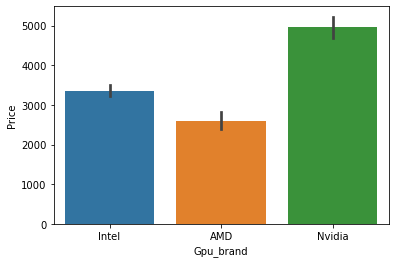

In [32]:
# GPU column

def fetch_gpu(x):
    gpu = " ".join(x.split()[0])
    if gpu == 'AMD':
        return 'AMD gpu'
    elif gpu == 'Nvidia':
        return 'Nvidia gpu'
    else:
        return 'Intel cpu'

#data['Gpu_company'] = data['Gpu'].apply(lambda x: fetch_gpu(x))

data['Gpu_brand'] = data['Gpu'].apply(lambda x: x.split()[0])
data = data[data['Gpu_brand'] != 'ARM']

data.drop(columns=['Gpu'],inplace=True)

sns.barplot(x=data['Gpu_brand'],y=data['Price'])
plt.show()

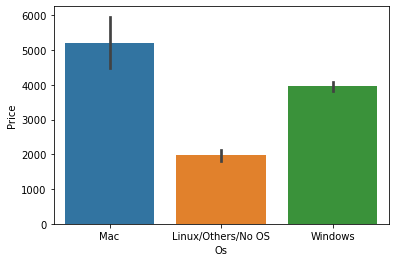

In [33]:
# OS column

def fetch_os(x):
    if x == 'Windows 10' or x == 'Windows 7' or x == 'Windows 10 S':
        return 'Windows'
    elif x == 'macOS' or x=='Mac OS X':
        return 'Mac'
    else:
        return 'Linux/Others/No OS'

data['Os'] = data['OpSys'].apply(lambda x: fetch_os(x))
data.drop(columns=['OpSys'],inplace=True)

sns.barplot(x=data['Os'],y=data['Price'])
plt.show()


c:\Users\Galax\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

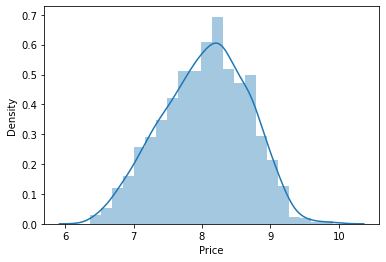

In [34]:

sns.distplot(np.log(data['Price']))
plt.show



# Machine Learning Part

In [35]:
#Import models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR


# Split the data to train and test data



X= data.drop(columns=['Price'])

y = np.log(data['Price'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=2)




In [36]:
#TESTING
#'''
#Linear Reggresion
#R2 score 0.8066202760883244
#MAE 0.21060313071356285
#
#Random Forest Regresson
#R2 score 0.8771330698683409
#MAE 0.1666083035886323
#
#KNeighborsRegressor
#R2 score 0.7819519515446344
#MAE 0.1944067651452086
#
#DecisionTreeRegressor
#R2 score 0.8376241289744799
#MAE 0.19186180203262584
#
#SVR
#R2 score 0.7730465236098295
#MAE 0.20846463994046804
#'''

Implementing Pipeline for testing and training

In [37]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf', OneHotEncoder(sparse = False, drop='first'),[0,1,7,10,11])
    ],remainder='passthrough')

#step2 = LinearRegression()
#step2 = KNeighborsRegressor(n_neighbors=9,weights='distance',algorithm='auto')
#step2 = DecisionTreeRegressor(max_depth=15,random_state=0,max_features=0.75)
#step2 = SVR(kernel='rbf',C=3,gamma=0.15)
step2 = RandomForestRegressor(n_estimators=100,random_state=3,max_samples=0.5,max_features=0.75,max_depth=15)
pipe = Pipeline([('step1',step1),('step2',step2)])

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print('R2 score', r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.8748767504094125
MAE 0.1663104263566303


In [38]:
#Exporting the model
import pickle

data.to_csv("df.csv",index=False)
pickle.dump(pipe,open('pipe.pkl','wb'))